In [5]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/spring20/setup_colab.sh -O- | bash

    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/coursera/grading.py -O ../grading.py
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/coursera/week1_intro/submit.py

    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

(Reading database ... 144793 files and directories currently installed.)
Preparing to unpack .../xserver-common_2%3a1.19.6-1ubuntu4.8_all.deb ...
Unpacking xserver-common (2:1.19.6-1ubuntu4.8) over (2:1.19.6-1ubuntu4.7) ...
Selecting previously unselected package xvfb.
Preparing to unpack .../xvfb_2%3a1.19.6-1ubuntu4.8_amd64.deb ...
Unpacking xvfb (2:1.19.6-1ubuntu4.8) ...
Setting up xserver-common (2:1.19.6-1ubuntu4.8) ...
Setting up xvfb (2:1.19.6-1ubuntu4.8) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Starting virtual X frame buffer: Xvfb.


In [6]:
import gym 
import numpy as np 
try: 
  env = gym.make("Taxi-v3")
except gym.error.DepractedEnv:
  env = gym.make("Taxi-v2")
env.reset()
env.render()
    

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [7]:
n_states = env.observation_space.n
n_actions = env.action_space.n
print("n_states=%i,n_actions=%i"%(n_states,n_actions))
print("observation: %s" % env.observation_space)
print("action: %s" %env.action_space)


n_states=500,n_actions=6
observation: Discrete(500)
action: Discrete(6)


In [8]:
policy = np.ones((n_states,n_actions)) * (1.0/n_actions)
print(policy[10,:])

[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]


In [9]:
assert type(policy) in (np.ndarray,np.matrix)
assert np.allclose(policy,1./n_actions)
assert np.allclose(np.sum(policy,axis = 1),1)


In [10]:
def generate_session(env, policy, t_max=10**4):
    states, actions = [], []
    total_reward = 0.

    s = env.reset()

    for t in range(t_max):

        a = np.random.choice(n_actions, p=policy[s,:])
        new_s, r, done, info = env.step(a)
        states.append(s)
        actions.append(a)
        total_reward += r

        s = new_s
        if done:
            break
    return states, actions, total_reward

In [11]:
s,a,r = generate_session(env,policy)
assert type(s) == type(a) == list 
assert len(s) == len(a)
assert type(r) in [float,np.float]


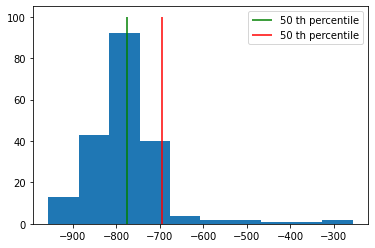

In [12]:
import matplotlib.pyplot as plt 
sample_rewards = [generate_session(env,policy,t_max = 1000)[-1] for _ in range(200)]
plt.hist(sample_rewards)
plt.vlines([np.percentile(sample_rewards,50)],[0],[100],label = "50 th percentile",color = "green")
plt.vlines([np.percentile(sample_rewards,90)],[0],[100],label = "50 th percentile",color = "red")
plt.legend()   

In [13]:
def select_elites(states_batch,actions_batch,rewards_batch,percentile):
  reward_threshold = np.percentile(rewards_batch,percentile)
  elite_ids = rewards_batch >= reward_threshold 
  elite_states = []
  elite_actions = []
  for id,val in enumerate(elite_ids):
    if val:
      elite_states.extend([s for s in states_batch[id]])
      elite_actions.extend([a for a in actions_batch[id]])
  print(elite_states)
  print(elite_actions)
  return elite_states,elite_actions 
        


In [14]:
states_batch = [
    [1, 2, 3],     
    [4, 2, 0, 2],  
    [3, 1],        
]

actions_batch = [
    [0, 2, 4],     
    [3, 2, 0, 1],  
    [3, 3],        
]
rewards_batch = [
    3,  
    4,  
    5,  
]
test_result_0 = select_elites(states_batch,actions_batch,rewards_batch,percentile = 0)
test_result_30 = select_elites(states_batch,actions_batch,rewards_batch,percentile = 30)
test_result_50 = select_elites(states_batch,actions_batch,rewards_batch,percentile = 50)
test_result_90 = select_elites(states_batch,actions_batch,rewards_batch,percentile = 90)

[1, 2, 3, 4, 2, 0, 2, 3, 1]
[0, 2, 4, 3, 2, 0, 1, 3, 3]
[4, 2, 0, 2, 3, 1]
[3, 2, 0, 1, 3, 3]
[4, 2, 0, 2, 3, 1]
[3, 2, 0, 1, 3, 3]
[3, 1]
[3, 3]


In [15]:
def update_policy(elite_states,elite_actions):
  new_policy = np.zeros([n_states,n_actions])
  for s,a in zip(elite_states,elite_actions):
    new_policy[s][a] += 1
  sum_of_rows = new_policy.sum(axis =1)
  for idx,r in enumerate(sum_of_rows):
    if r == 0:
      new_policy[idx] = np.ones([n_actions])/n_actions 
    else:
      new_policy[idx] = new_policy[idx]/r
  return new_policy       


In [16]:
elite_states = [1, 2, 3, 4, 2, 0, 2, 3, 1]
elite_actions = [0, 2, 4, 3, 2, 0, 1, 3, 3]
new_policy = update_policy(elite_states,elite_actions)


In [25]:
from IPython.display import clear_output

def show_progress(rewards_batch, log, percentile, reward_range=[-990, +10]):
  
    mean_reward = np.mean(rewards_batch)

    max_reward = np.max(rewards_batch)
    min_reward = np.min(rewards_batch)

    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold, max_reward, min_reward])
    
    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[0], label='Mean rewards')
    plt.plot(list(zip(*log))[1], label='Reward thresholds')

    plt.fill_between(range(len(log)), list(zip(*log))[2],list(zip(*log))[3], facecolor='blue', alpha=0.2)
   
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.hist(rewards_batch, range=reward_range)
    plt.vlines([np.percentile(rewards_batch, percentile)],
               [0], [100], label="percentile", color='red')
    plt.legend()
    plt.grid()
    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f" % (mean_reward, threshold))
    plt.show()

In [26]:
policy = np.ones([n_states,n_actions])/n_actions

mean reward = -81.184, threshold=1.500


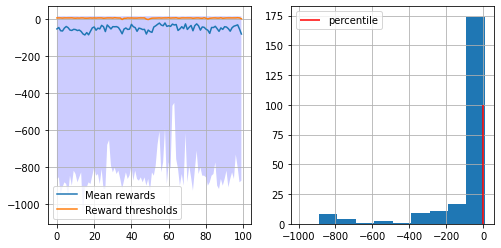

In [30]:
n_sessions = 250 
percentile = 50 
learning_rate = 0.5  

log = []

for i in range(100):

   
    %time sessions = [generate_session(env, policy) for _ in range(n_sessions)]

    states_batch, actions_batch, rewards_batch = zip(*sessions)

   
    elite_states, elite_actions = select_elites(states_batch,actions_batch,rewards_batch,percentile)

    
    new_policy = update_policy(elite_states,elite_actions)
    
    policy = learning_rate*new_policy + (1-learning_rate)*policy

    
    show_progress(rewards_batch, log, percentile)


In [31]:
from time import sleep

t_max = 10**4
total_reward = 0.

s = env.reset()

for t in range(t_max):

    
    a = np.random.choice(n_actions, p=policy[s,:])

    new_s, r, done, info = env.step(a)
    
    clear_output(True)
    env.render()
    print("T_reward: %f" % total_reward)
    sleep(0.1)
    
 
    total_reward += r

    s = new_s
    if done:
        break

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
T_reward: -12.000000
